In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 13 11:34:26 2020

Script for lesson 6 of "Friends of Tracking" #FoT

Data can be found at: https://github.com/metrica-sports/sample-data

Accompanying video tutorials can be found here: https://www.youtube.com/watch?v=5X1cSehLg6s

GitHub repo: https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking

@author: Laurie Shaw (@EightyFivePoint)
"""

'\nCreated on Mon Apr 13 11:34:26 2020\n\nScript for lesson 6 of "Friends of Tracking" #FoT\n\nData can be found at: https://github.com/metrica-sports/sample-data\n\nAccompanying video tutorials can be found here: https://www.youtube.com/watch?v=5X1cSehLg6s\n\nGitHub repo: https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking\n\n@author: Laurie Shaw (@EightyFivePoint)\n'

In [1]:
!pip install git+https://github.com/devinpleuler/analytics-handbook.git

  Cloning https://github.com/devinpleuler/analytics-handbook.git to /private/var/folders/44/8nnf_10n2dvb6hcqyl5bwdz00000gp/T/pip-req-build-znyvbp9a
  Stored in directory: /private/var/folders/44/8nnf_10n2dvb6hcqyl5bwdz00000gp/T/pip-ephem-wheel-cache-9xovt3na/wheels/a2/15/03/3c591dabe6796a88ecf1e560f2a7ae69f5d6c5713113ed3341
Successfully built AnalyticsHandbook
You are using pip version 19.1.1, however version 20.1b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from soccerutils.statsbomb import events_to_pandas

ModuleNotFoundError: No module named 'soccerutils'

In [2]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import numpy as np

In [5]:
# set up initial path to data
DATADIR = 'data'
game_id = 2 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

Reading team: home
Reading team: away


In [6]:
""" **** pitch control for passes leading up to goal 2 **** """

# get all shots and goals in the match
shots = events[events['Type']=='SHOT']
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()

print(goals)

      Team  Type              Subtype  Period  Start Frame  Start Time [s]  \
198   Home  SHOT       ON TARGET-GOAL       1        12202          488.08   
823   Away  SHOT       ON TARGET-GOAL       1        53049         2121.96   
1118  Home  SHOT  HEAD-ON TARGET-GOAL       2        73983         2959.32   
1671  Away  SHOT       ON TARGET-GOAL       2       115009         4600.36   
1723  Home  SHOT       ON TARGET-GOAL       2       121027         4841.08   

      End Frame  End Time [s]      From   To  Start X  Start Y  End X  End Y  
198       12212        488.48  Player10  NaN   -47.70    -3.40 -54.06  -2.04  
823       53075       2123.00  Player24  NaN    44.52     2.72  54.06   1.36  
1118      73995       2959.80   Player9  NaN   -47.70     1.36 -54.06   2.04  
1671     115024       4600.96  Player20  NaN    40.28     1.36  55.12   2.72  
1723     121055       4842.20  Player12  NaN   -30.74     5.44 -54.06   2.72  


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1122b07c0>)

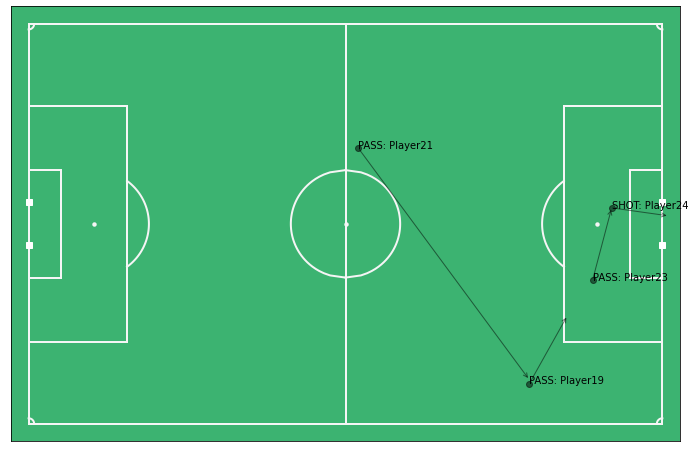

In [7]:
# plot the 3 events leading up to the second goal
mviz.plot_events( events.loc[820:823], color='k', indicators = ['Marker','Arrow'], annotate=True )

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1109d1430>)

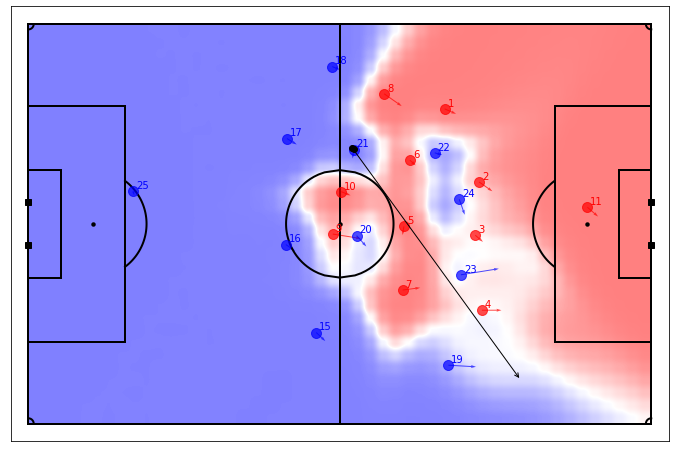

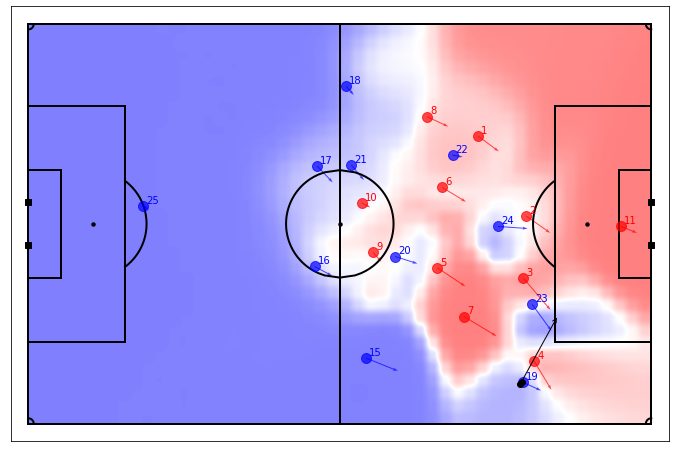

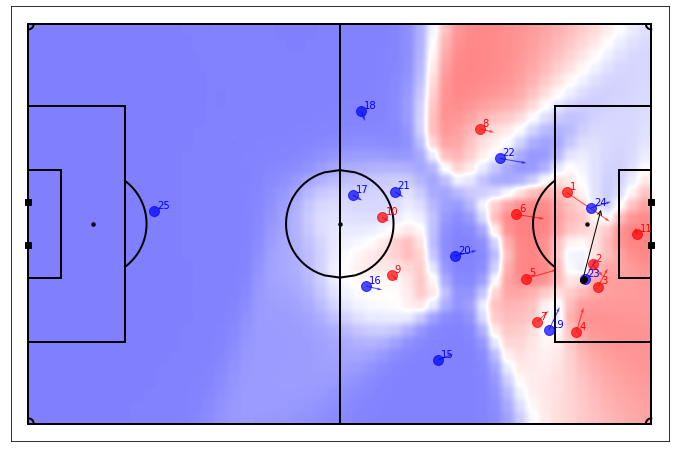

In [8]:
# first get model parameters
params = mpc.default_model_params(3)

# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(820, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 820, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )
# evaluated pitch control surface for second pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(821, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 821, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )
# evaluated pitch control surface for third pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(822, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 822, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )

In [9]:
""" **** calculate pass probability for every home team succesful pass **** """
# get all home passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]

# list for storing pass probablities
pass_success_probability = []

for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params)
    defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params)
    Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability.append( (i,Patt) )
    

Text(0, 0.5, 'Frequency')

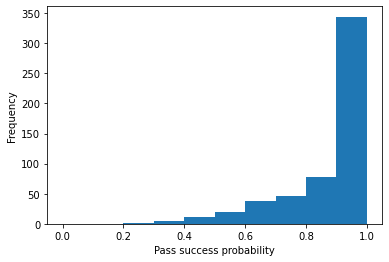

In [10]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  

Event following a risky (completed) pass
0.26455950351294005 CHALLENGE
0.28505234723760897 BALL LOST
0.3006628396711591 SHOT
0.31160841865474626 CHALLENGE
0.33704347298090714 CHALLENGE
0.3913125864694877 SHOT
0.4188148605128081 BALL LOST
0.4194468674048554 CHALLENGE
0.4204267746341931 PASS
0.4312712628523871 CHALLENGE
0.44436475742157466 CHALLENGE
0.44844895551994096 PASS
0.4593665151483775 CHALLENGE
0.4635633533167435 SHOT
0.468048170879984 CHALLENGE
0.4897275563912591 CHALLENGE
0.4900872646495704 CHALLENGE
0.4927699899300238 SHOT
0.5001349056944236 PASS
0.5026909720011078 PASS


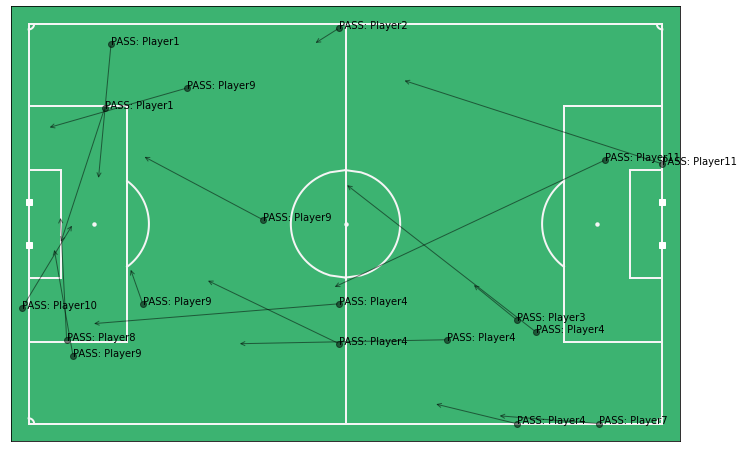

In [11]:
# sort the passes by pitch control probability
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]

# plot the events
mviz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )

# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[ p[0]+1 ].Type
    print( p[1], outcome )